# Phase Retrieval Tutorial

In [9]:
%pylab inline
from pyotf.otf import HanserPSF
from pyotf.phaseretrieval import retrieve_phase
from pyotf.zernike import zernike

Populating the interactive namespace from numpy and matplotlib


In [15]:
# model kwargs
model_kwargs = dict(
    wl=0.525,
    na=1.27,
    ni=1.33,
    res=0.1,
    size=128,
    zsize=32,
    zres=0.250,
    vec_corr="none",
    condition="none",
)
# make the model
model = HanserPSF(**model_kwargs)
# extract kr
model._gen_kr()
kr = model._kr
theta = model._phi
# make zernikes (need to convert kr to r where r = 1 when kr is at
# diffraction limit)
r = kr * model.wl / model.na
mask = r <= 1
zerns = zernike(r, theta, np.arange(5, 16))
# make fake phase and magnitude coefs
np.random.seed(12345)
pcoefs = np.random.randn(zerns.shape[0])
mcoefs = np.random.rand(zerns.shape[0])
pupil_phase = (zerns * pcoefs[:, np.newaxis, np.newaxis]).sum(0)
pupil_mag = (zerns * mcoefs[:, np.newaxis, np.newaxis]).sum(0)
pupil_mag = pupil_mag + model._gen_pupil() * (2.0 - pupil_mag.min())
# phase only test
model.apply_pupil(pupil_mag * np.exp(1j * pupil_phase) * model._gen_pupil())
PSFi = np.random.poisson(model.PSFi / model.PSFi.max() * 1000) + np.random.randn(*model.PSFi.shape)
# we have to converge really close for this to work.
PR_result = retrieve_phase(
    PSFi, model_kwargs, max_iters=200, pupil_tol=0, mse_tol=0, phase_only=False
)

Reach max iterations without convergence


(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Magnitude Coefficients'}>,
        <AxesSubplot:title={'center':'Phase Coefficients'}, xlabel="Noll's Number">],
       dtype=object))

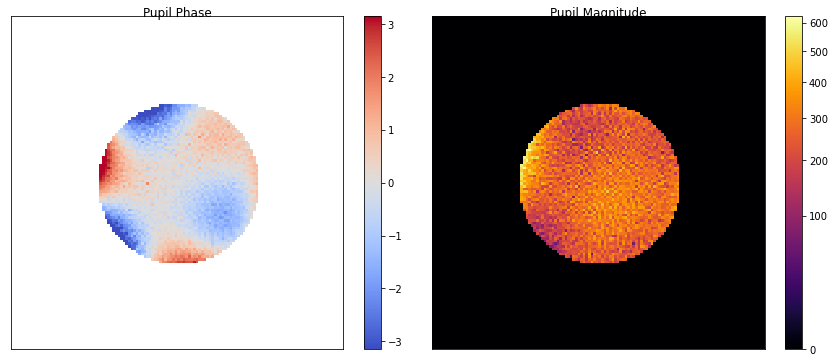

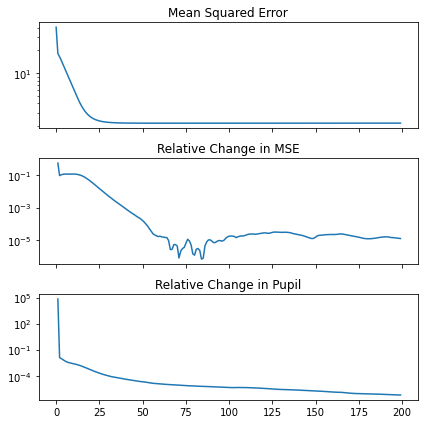

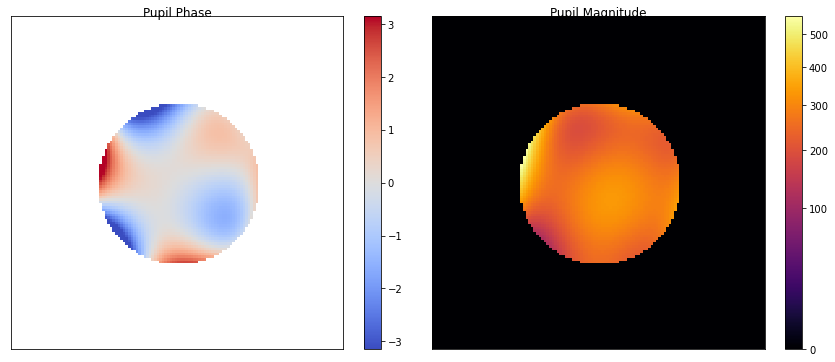

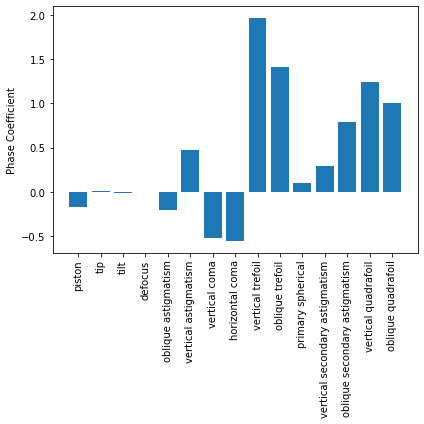

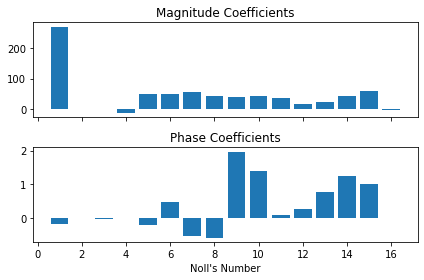

In [16]:
PR_result.plot()
PR_result.plot_convergence()
PR_result.fit_to_zernikes(16)
PR_result.zd_result.plot()
PR_result.zd_result.plot_named_coefs()
PR_result.zd_result.plot_coefs()

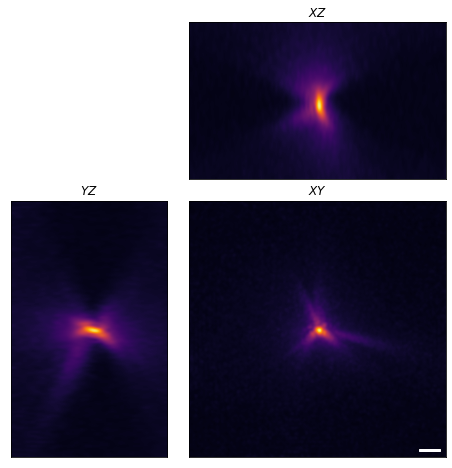

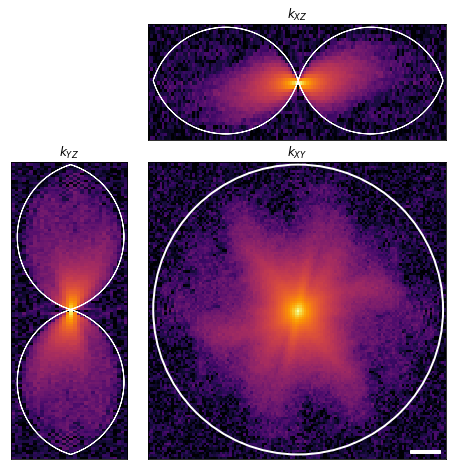

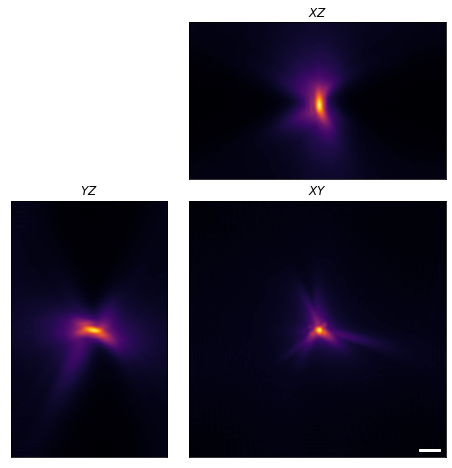

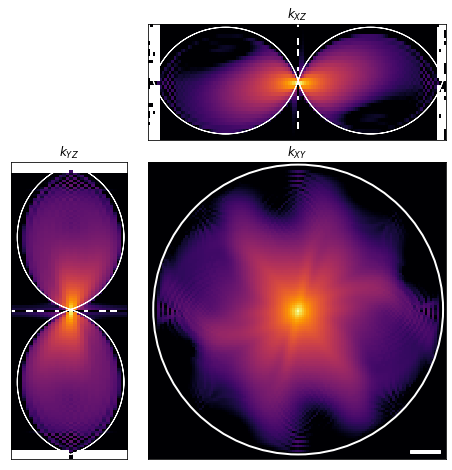

In [17]:
import dphtools.display as dplt
from pyotf.utils import easy_fft
for d in (PSFi, PR_result.generate_zd_psf()):
    dplt.psf_plot(d, 1.27, 1.33, 1.33, zstep=model_kwargs["zres"], pixel_size=model_kwargs["res"], norm=mpl.colors.PowerNorm(0.5), interpolation="bicubic")
    otf = abs(easy_fft(d))
    dplt.otf_plot(otf / otf.max(), 1.27, 0.525, 1.33, 1.33, model_kwargs["zres"], model_kwargs["res"], vmin=1e-3)

(-0.5, 127.5, 127.5, -0.5)

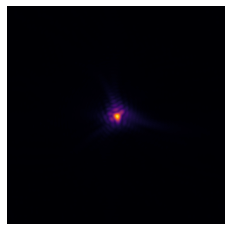

In [18]:
imshow(d[len(d) // 2], norm=mpl.colors.PowerNorm(0.5), interpolation="bicubic", cmap="inferno")
plt.axis("off")